# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import os
import re
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

In [2]:
# data_path = os.path.join(os.path.dirname(os.getcwd()), "data", "liver2.csv")
data_path = os.path.join(os.path.dirname(os.getcwd()), "data", "case_duration_all.csv")

df = pd.read_csv(data_path)

c:\users\liuda\anaconda3\envs\lp_pyomo\lib\site-packages\IPython\core\interactiveshell.py:3221: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df.dropna()

,Actual Room Duration,Scheduled Room Duration,Room,Primary Service,Primary Surgeon Name,Number of Panels,Age at Surgery,Height (cm),Weight (kg),BMI,Sex,Primary Procedure CPT Code
10,330.0,405.0,MAIN_OR 17,GYN - GYNECOLOGIC ONCOLOGY,"SOOD, ANIL",1,42,162.00120,139.330625,24.08,Female,58957
25,137.0,40.0,MAIN_OR 09,HN - HEAD & NECK SURGERY,"ZHAO, XIAO",2,67,185.99912,179.454375,24.43,Male,92502
35,35.0,35.0,WR ENDO 1,GASTROENTEROLOGY,"AL-ASADI, MAZEN",1,61,165.99916,168.651875,27.76,Female,45378
39,34.0,35.0,WR ENDO 1,GASTROENTEROLOGY,"AL-ASADI, MAZEN",1,50,178.00066,215.389375,30.84,Male,45378
117,26.0,25.0,ENDO 7,GASTROENTEROLOGY,"LYNCH, PATRICK M.",1,73,152.00122,179.013750,36.10,Female,43235
...,...,...,...,...,...,...,...,...,...,...,...,...
1087846,47.0,40.0,ENDO 6,GASTROENTEROLOGY,"RHIM, ANDREW D",1,84,167.59936,184.304375,25.28,Male,45378
1087850,256.0,150.0,MAIN_OR 21,SURG ONC - GENERAL,"SANTOS, DAVID",1,84,167.59936,179.013750,25.28,Male,49505
1087871,255.0,215.0,MAIN_OR 32_BRAIN SUITE,NEUROSURGERY,"PRABHU, SUJIT",1,42,164.00018,120.591875,20.34,Female,61750
1087876,33.0,40.0,ENDO 4,GASTROENTEROLOGY,"BRESALIER, ROBERT",1,64,180.50002,274.252500,38.18,Male,45378


In [4]:
df['Primary Procedure CPT Code']=df['Primary Procedure CPT Code'].str.replace('\D+','')
df = df.dropna() # drop cases without all information
limit = 480
df=df[df['Actual Room Duration']<limit]
bmi_limit = 80
df=df[df['BMI']<bmi_limit]
height_limit = 100
df=df[df['Height (cm)']>height_limit]
df['Primary Procedure CPT Code']=df['Primary Procedure CPT Code'].astype(int)

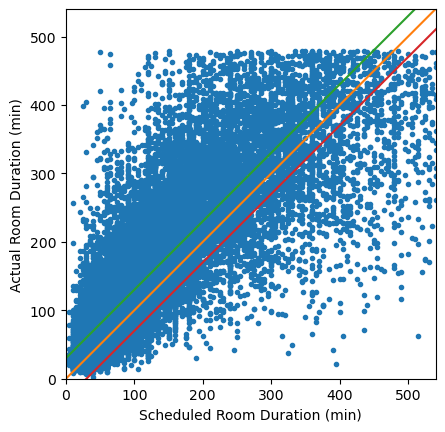

In [5]:
plt.plot(df['Scheduled Room Duration'],df['Actual Room Duration'],'.')
plt.gca().set_aspect('equal')
plt.plot((0, 1000), (0, 1000))
plt.plot((0, 1000), (30, 1030))
plt.plot((0, 1000), (-30, 970))
plt.xlim(0, limit+60)
plt.ylim(0, limit+60)
plt.xlabel('Scheduled Room Duration (min)')
plt.ylabel('Actual Room Duration (min)')
plt.show()

Text(0.5, 0, 'Age (years)')

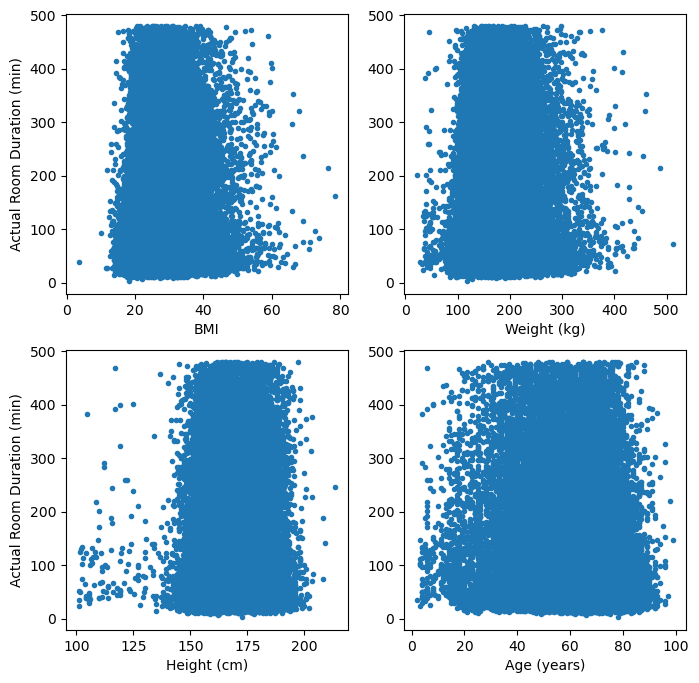

In [6]:
fig, axs = plt.subplots(2,2, figsize=(8,8))
axs[0,0].plot(df['BMI'],df['Actual Room Duration'],'.')
axs[0,0].set_xlabel('BMI')
axs[0,0].set_ylabel('Actual Room Duration (min)')
axs[0,1].plot(df['Weight (kg)'],df['Actual Room Duration'],'.')
axs[0,1].set_xlabel('Weight (kg)')
axs[1,0].plot(df['Height (cm)'],df['Actual Room Duration'],'.')
axs[1,0].set_xlabel('Height (cm)')
axs[1,0].set_ylabel('Actual Room Duration (min)')
axs[1,1].plot(df['Age at Surgery'],df['Actual Room Duration'],'.')
axs[1,1].set_xlabel('Age (years)')

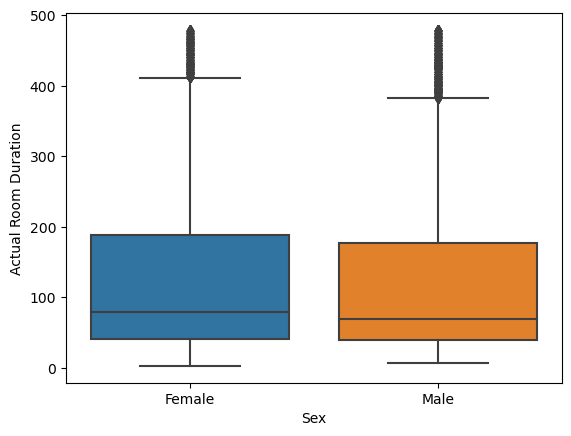

In [7]:
sb.boxplot( x = 'Sex',y = 'Actual Room Duration', data = df )

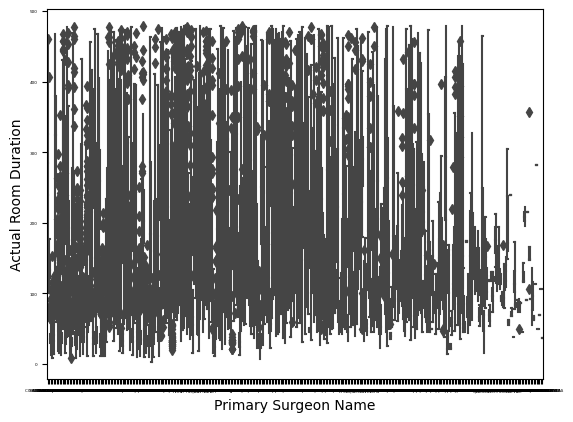

In [8]:
b = sb.boxplot( x = 'Primary Surgeon Name',y = 'Actual Room Duration', data = df )
b.tick_params(labelsize=3)

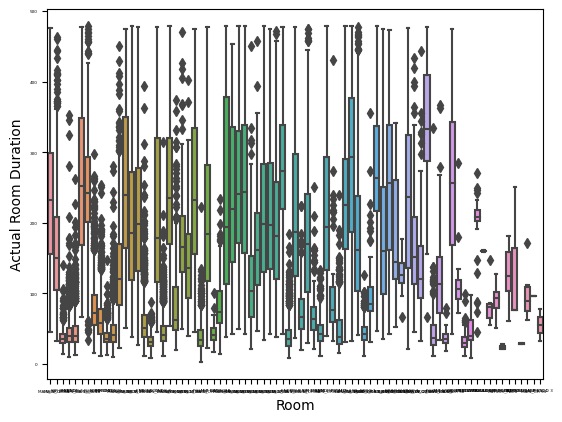

In [9]:
b = sb.boxplot(x = 'Room',y = 'Actual Room Duration', data = df )
b.tick_params(labelsize=3)

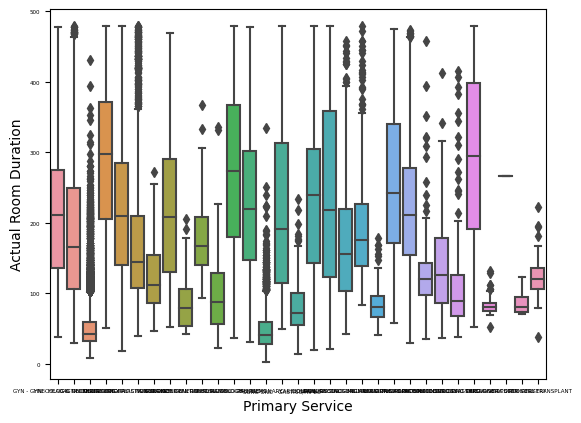

In [10]:
b = sb.boxplot(x = 'Primary Service',y = 'Actual Room Duration', data = df )
b.tick_params(labelsize=4)

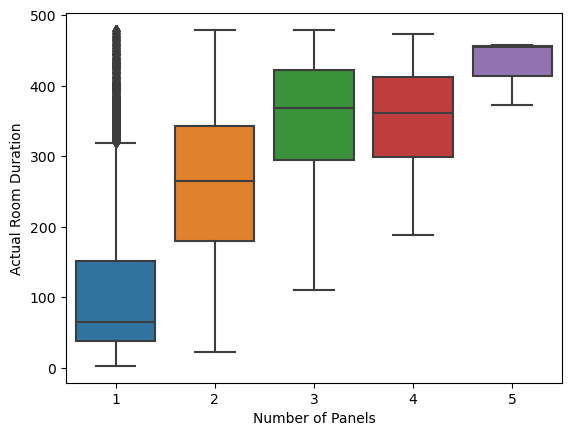

In [11]:
b = sb.boxplot(x = 'Number of Panels',y = 'Actual Room Duration', data = df )

In [12]:
features_to_encode = ['Primary Surgeon Name', 'Primary Service', 'Sex', 'Room']
col_trans = make_column_transformer(
                        (OneHotEncoder(),features_to_encode),
                        remainder = "passthrough"
                        )

In [13]:
# X = df[['Primary Surgeon Name', 'Primary Service', 'Sex','Room','Number of Panels','Scheduled Room Duration', 'BMI', 'Age at Surgery', 'Height (cm)','Weight (kg)']]
# X = df[['Primary Surgeon Name', 'Primary Service', 'Sex','Room','Number of Panels','Scheduled Room Duration', 'BMI', 'Age at Surgery', 'Height (cm)','Weight (kg)', 'Primary Procedure CPT Code']]
X = df[['Primary Surgeon Name', 'Primary Service', 'Sex','Room','Number of Panels', 'BMI', 'Age at Surgery', 'Height (cm)','Weight (kg)', 'Primary Procedure CPT Code']]
y = df['Actual Room Duration']

In [14]:
# model = LinearRegression()
model = GradientBoostingRegressor()
pipe = make_pipeline(col_trans, model)
pipe.fit(X, y)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['Primary Surgeon Name',
                                                   'Primary Service', 'Sex',
                                                   'Room'])],
                                   verbose=...
  

In [15]:
y_pred = pipe.predict(X)

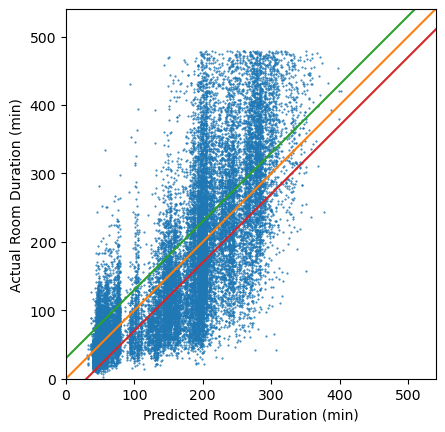

In [16]:
plt.plot(y_pred,y,'.', MarkerSize=1)
plt.gca().set_aspect('equal')
plt.plot((0, 1000), (0, 1000))
plt.plot((0, 1000), (30, 1030))
plt.plot((0, 1000), (-30, 970))
plt.xlim(0, limit+60)
plt.ylim(0, limit+60)
plt.xlabel('Predicted Room Duration (min)')
plt.ylabel('Actual Room Duration (min)')
plt.show()

In [17]:
def encode_and_bind(original_dataframe, features_to_encode):
    dummies = pd.get_dummies(original_dataframe[features_to_encode])
    res = pd.concat([dummies, original_dataframe], axis=1)
    res = res.drop(features_to_encode, axis=1)
    return(res)
X_train_encoded = encode_and_bind(X, features_to_encode)

In [18]:
def encode_and_bind(original_dataframe, features_to_encode):
    dummies = pd.get_dummies(original_dataframe[features_to_encode])
    res = pd.concat([dummies, original_dataframe], axis=1)
    res = res.drop(features_to_encode, axis=1)
    return(res)
X_train_encoded = encode_and_bind(X, features_to_encode)

In [19]:
feature_importances = list(zip(X_train_encoded, model.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked];

Feature: Primary Service_GASTROENTEROLOGY    Importance: 0.5248482796304152
Feature: Primary Service_PULMONARY           Importance: 0.17511791643640282
Feature: Primary Procedure CPT Code          Importance: 0.11996701263889656
Feature: Number of Panels                    Importance: 0.0726050780444041
Feature: Primary Service_NEUROSURGERY        Importance: 0.024169379818359493
Feature: Room_MAYS_OR 01                     Importance: 0.0076193663930690415
Feature: Primary Service_UROLOGY             Importance: 0.006980462544049355
Feature: Room_MAIN_OR 20                     Importance: 0.005829866216967256
Feature: Room_MAIN_OR 31_ROBOTIC             Importance: 0.004834713494498857
Feature: Room_FLUORO 1                       Importance: 0.004635208672164021
Feature: Primary Service_RADIATION ONCOLOGY  Importance: 0.003371034126474816
Feature: Primary Service_THRCV - THORACIC SURGERY Importance: 0.0032713937683204655
Feature: Primary Service_CARDIOLOGY          Importance: 0.0032

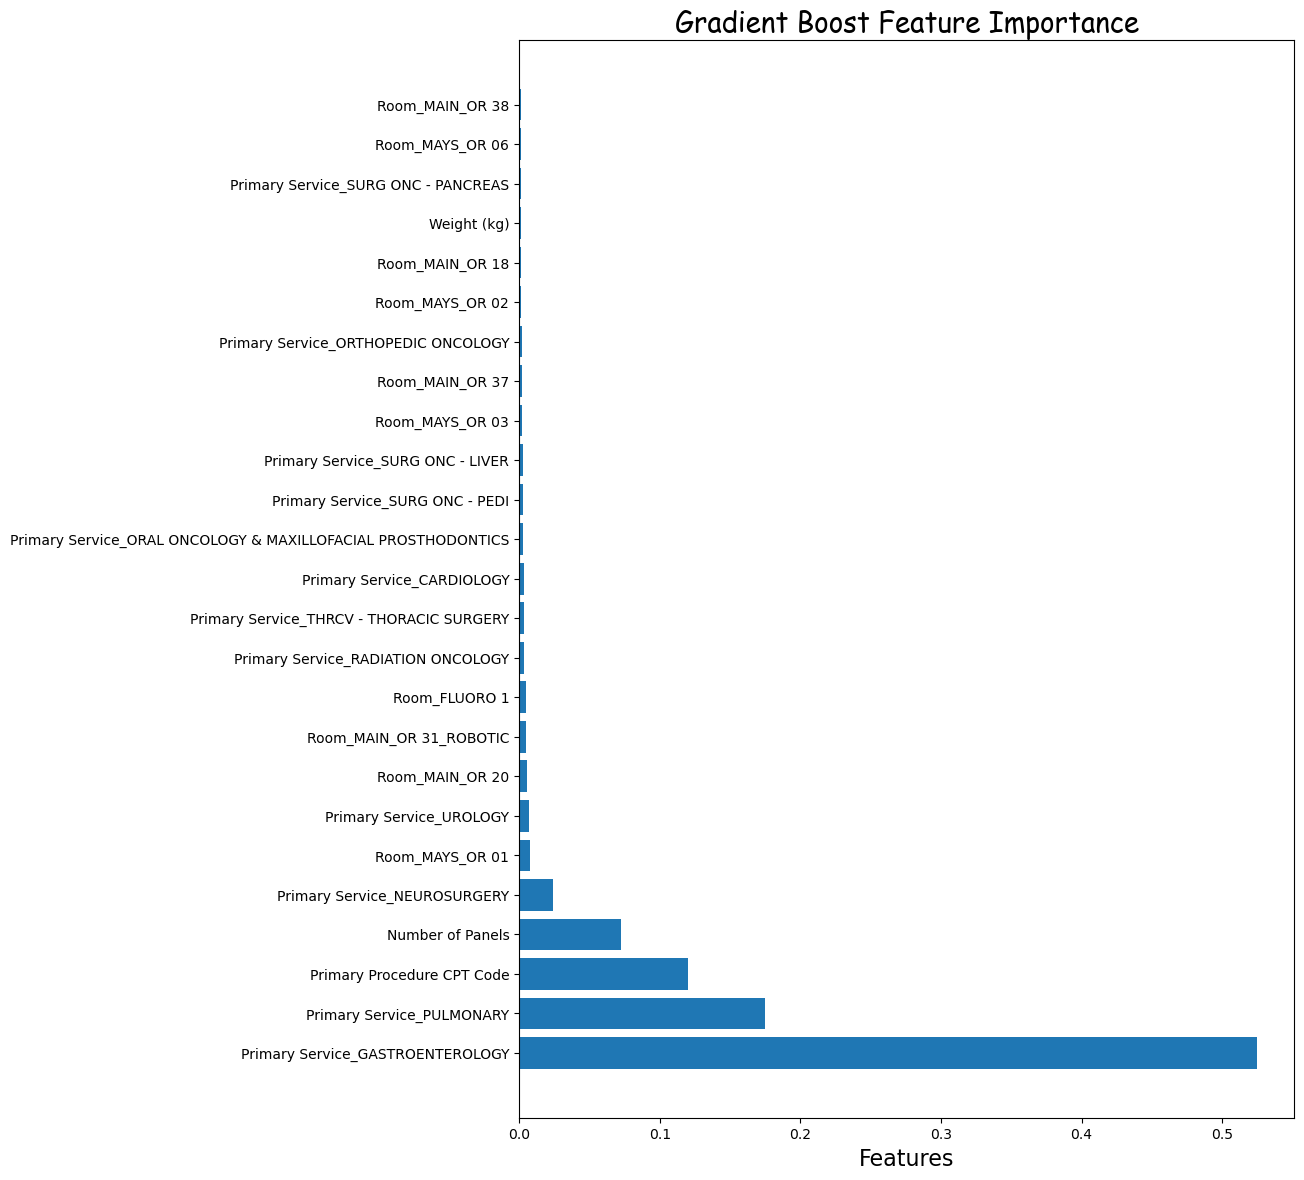

In [20]:
feature_names_25 = [i[0] for i in feature_importances_ranked[:25]]
y_ticks = np.arange(0, len(feature_names_25))
x_axis = [i[1] for i in feature_importances_ranked[:25]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_25, x_axis)   #horizontal barplot
plt.title('Gradient Boost Feature Importance',
          fontdict= {'fontname':'Comic Sans MS','fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()